# Mapping Chemical Space with UMAP

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Zzg5JlDGsvFSakiDLwnNc27HeVaLyu1V?usp=sharing)

**Content**:
1. Create 2D visualization of Blood Brain Barrier Permeability (BBBP) dataset with UMAP, PCA and T-SNE embedding
2. Embed own compounts into the embedding

**The dataset**:  
The BBBP (Blood-Brain Barrier Penetration) dataset from [MoleculeNet](https://moleculenet.org/datasets-1) contains information on molecules and their ability to penetrate the blood-brain barrier, which is crucial for drug discovery and development.

**The method**:  
The UMAP method is an example of *unsupervised* machine learning since the data is processed without knowing its label.

**Methodology**:
- This notebook has gaps that you have to fill. If all gaps are filled in correctly, the notebook can be run.
- A solution notebook with all gaps filled is provided in the GitHub repository.
- Gaps are marked with a `#TODO`

This notebook has been created being inspired by or using content from [Source Notebook on Google Colab](https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb#scrollTo=dzmJAwfiAi6k)

## 1. Import libraries and data
Here all necessary libraries are imported and the necessary data is fetched. Also helper functions are set up.

- `os`: Provides functions to interact with the operating system, such as checking file existence.
- `pandas`: Used for data manipulation and analysis.
- `numpy`: Provides support for numerical computations.
- `seaborn`: A visualization library based on matplotlib for statistical graphics.
- `matplotlib.pyplot`: A plotting library for creating static, animated, and interactive visualizations.
- `rdkit`: A toolkit for cheminformatics, used for handling chemical information.
- `sklearn`: A machine learning library for data analysis and modeling.
- `umap.umap_`: A library for dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection).

In [15]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sklearn
import umap.umap_ as umap

from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

In [16]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

We also define the following three helper functions that we need later in the notebook.

In [17]:
def get_largest_fragment_from_smiles(s: str):
    """
    Get the largest fragment from a SMILES string.
    Args:
        s: SMILES string
    Returns:
        str: SMILES string of the largest fragment
    """
    mol = rdkit.Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return rdkit.Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list):
    """ 
    Computes ecfp descriptors for a list of SMILES strings.
    Args:
        smiles_list: list of SMILES strings
    Returns: 
        np.array: ECFP descriptors
        list: list of indices of the SMILES strings that were successfully converted
    """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    """"
    Computes ECFP descriptors for a single SMILES string.
    Args:
        smiles: SMILES string
    Returns:
        np.array: ECFP descriptors
    """
    try:
        mol = rdkit.Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

Load data if neccesary (For example if this notebook is used in a Google colab, the data has to be retrieved and saved from the online GitHub repository).

In [18]:
import urllib.request

if not os.path.exists('data/BBBP.csv'):
    url = "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/BBBP.csv"
    urllib.request.urlretrieve(url, "data/BBBP.csv")
    print("Data loaded from URL and saved locally")

bbbp = pd.read_csv("data/BBBP.csv")
bbbp.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


## 2. Embed BBBP dataset with UMAP

In this section, we embed the BBBP dataset into a lower-dimensional space using three different dimensionality reduction techniques: UMAP, PCA, and t-SNE. These methods help visualize the high-dimensional molecular data in a 2D space, making it easier to interpret patterns and relationships and to cluster the data.

- **UMAP (Uniform Manifold Approximation and Projection)**: A non-linear dimensionality reduction technique that preserves the local and global structure of the data. It is particularly effective for visualizing clusters and complex relationships.

### Read in and process data

In [19]:
# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
pd.DataFrame(bbbp).head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


### Compute ECFP Descriptors

In this section, the Extended Connectivity Fingerprints (ECFPs) are computed for the SMILES strings in the dataset. ECFPs are a type of molecular descriptor that encodes the structure of a molecule into a fixed-length binary vector. Read more about [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t).

In [20]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### 2.1 Embed with UMAP

**TODO**:
- Use the umap-learn library to define and fit a umap.UMAP object to the ecfp_descriptors

In [21]:
#TODO define the umap_reducer object as a umap.UMAP object with the following parameters:
# metric = "jaccard"
# n_neighbors = 25
# n_components = 2
# low_memory = False
# min_dist = 0.001
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
#TODO use the fit_transform method of the umap_reducer object to transform the ecfp_descriptors and assign the result to the umap_embedding variable
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]
pd.DataFrame(bbbp).head()

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


,smiles,permeable,name,UMAP_0,UMAP_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,10.178741,12.963213
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.124534,12.449201
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,9.717299,8.256157
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,11.513098,10.607658
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,7.680258,0.139356


### Visualize the dataset UMAP embeddeding

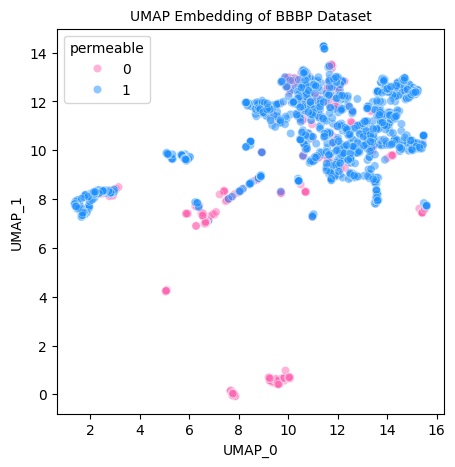

In [26]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
plt.figure(figsize=(5, 5))
sns.scatterplot(data=bbbp,
                x="UMAP_0",
                y="UMAP_1",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title(f"UMAP Embedding of BBBP Dataset", fontsize=10)
plt.show()

embed a few chemicals of interest into the umap

**Source of smiles descriptors**:
PubChem is a public repository for chemical information. It provides detailed data on chemical compounds, including their properties, structures, and biological activities. You can explore more at [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


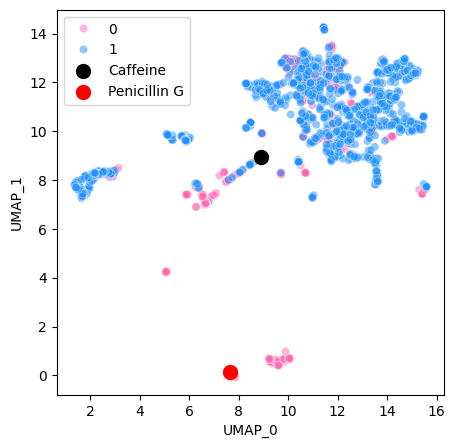

In [29]:
# embed a few chemicals of interest into the umap
chemicals = {
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "Penicillin G": "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"
}

descriptors = {name: _compute_single_ecfp_descriptor(smiles) for name, smiles in chemicals.items()}

transformed = {name: umap_reducer.transform([desc]) for name, desc in descriptors.items() if desc is not None}

permeable_compounds = bbbp[bbbp["permeable"] == 1]
non_permeable_compounds = bbbp[bbbp["permeable"] == 0]
# now show the embedding with the chemicals of interest
plt.figure(figsize=(5, 5))
# plt.scatter(
#     non_permeable_compounds["UMAP_0"], 
#     non_permeable_compounds["UMAP_1"], 
#     c="hotpink", 
#     label="Non-Permeable",
#     alpha=0.2
#     )
# plt.scatter(
#     permeable_compounds["UMAP_0"], 
#     permeable_compounds["UMAP_1"], 
#     c="dodgerblue", 
#     label="Permeable",
#     alpha=0.2
#     )
sns.scatterplot(data=bbbp,
                x="UMAP_0",
                y="UMAP_1",
                hue="permeable",
                alpha=0.5,
                palette=palette)
colors = ["black", "red"]
for (name, coords), color in zip(transformed.items(), colors):
    plt.scatter(coords[0][0], coords[0][1], label=name, s=100, color=color)
plt.legend()
plt.show()

#TODO (for fast people): Go to PubChem and find a molecule of interest, compute its ECFP descriptors and embed it into the UMAP plot.
